In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize  as opt
import scipy.ndimage as ndi
import scipy.signal as sig
import scipy.integrate as integ
import scipy.interpolate as inter

C:\Users\nomur\AppData\Local\Temp\ipykernel_15768\419080103.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(real_gas,v_element,p_element,maxfev=100000)


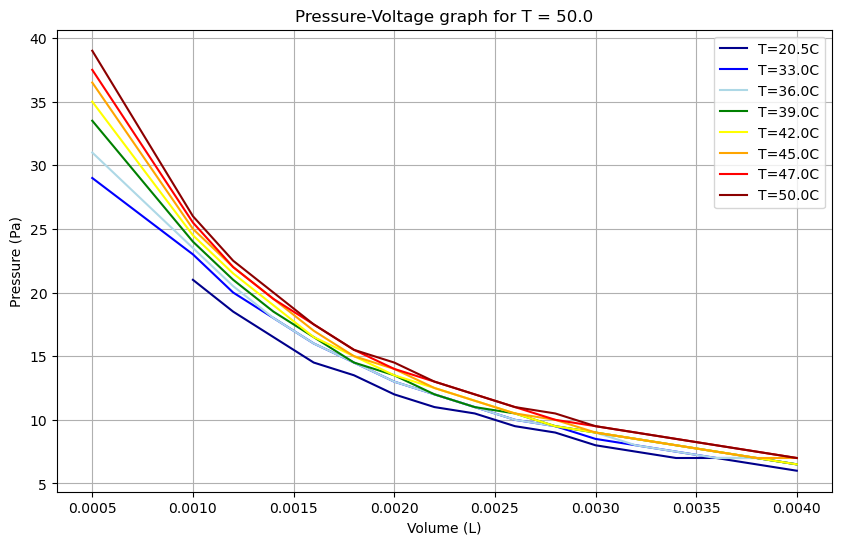

In [60]:
sheets = ["Sheet1","Sheet2","Sheet3","Sheet4","Sheet5","Sheet6","Sheet7","Sheet8"]
colors = ['darkblue','blue','lightblue','green','yellow','orange','red','darkred']
temperature = np.array([20.5,33,36,39,42,45,47,50])

datas = np.array([])
p_list = []
v_list = []

p_element_list = []
v_element_list = []

for i,p in enumerate(sheets):
    data = pd.read_excel('Data_modified.xlsx',p)
    datas = np.append(datas,data)
    p = []
    v = []
    for g in data['Pressure(E5)Pa']:
        p.append(g)
    for g in data['Volume(E-03)L']:
        v.append(g)
    p_list.append(p)
    v_list.append(v)



R = 8.314

plt.figure(figsize=(10, 6))
plt.title(f"Pressure-Voltage graph for T = {temperature[i]}")
plt.grid(True)
plt.xlabel("Volume (L)")
plt.ylabel("Pressure (Pa)")

for i,p in enumerate(sheets):
    T = temperature[i] + 273.15
    def real_gas(V,a,b,n,m,l):
        return (R*T)/(((V+l)/n)-b) - (a/(((V+l)/n)**2)) + m
    
    p_element = np.array(p_list[i]) 
    v_element = np.array(v_list[i]) * 1e-3

    p_element_list.append(p_element)
    v_element_list.append(v_element)

    v_clean = np.array([v_element[0]])
    for o in range(1,len(v_element)):
        v_clean = np.append(v_clean,np.sum(v_element[o]))
    v_clean.sort()

    v_fine = np.linspace(v_element.min(),v_element.max(),1000)
    cs = inter.CubicSpline(v_clean, p_element)
    p_fine = cs(v_fine)
   

    first_deriv = np.gradient(p_element,v_element)
    second_deriv = np.gradient(first_deriv,v_element)
    second_deriv_smooth = ndi.gaussian_filter1d(second_deriv,sigma=1)
    inflection_indicies = np.where(np.diff(np.sign(second_deriv_smooth)))[0]
    deriv_changing = np.argmax(np.abs(np.diff(first_deriv)))

    popt, pcov = opt.curve_fit(real_gas,v_element,p_element,maxfev=100000)

    points= 1000
    v_smooth = np.linspace(0,0.005,points)

    fit_line = real_gas(v_smooth,*popt)

    

    """
    for m,n in enumerate(p_element):
        if p_element[m-1] == p_element[m]:
            p = [p_element[m] for i in range(points)]
            plt.plot(v_smooth,p,color="green")

    """
    plt.plot(v_element, p_element, label=f"T={temperature[i]}C", color=colors[i])

    
    #plt.plot(v_smooth,fit_line,label="best fit line",color="red")

plt.legend()
plt.show()



Spinodal points:
  Local maximum: V = 0.003565 m³, P = 7.013 Pa
  Local minimum: V = 0.003447 m³, P = 6.977 Pa
6.994981445056424


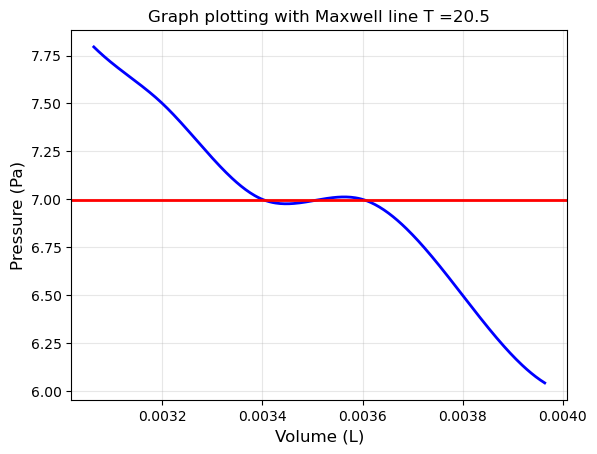


Spinodal points:
  Local maximum: V = 0.003793 m³, P = 7.000 Pa
  Local minimum: V = 0.003664 m³, P = 6.968 Pa
6.98412372220392


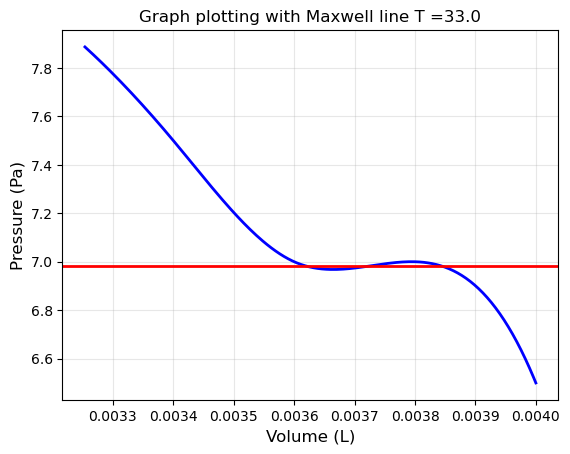


Spinodal points:
  Local maximum: V = 0.003800 m³, P = 7.000 Pa
  Local minimum: V = 0.003667 m³, P = 6.962 Pa
6.981196830504715


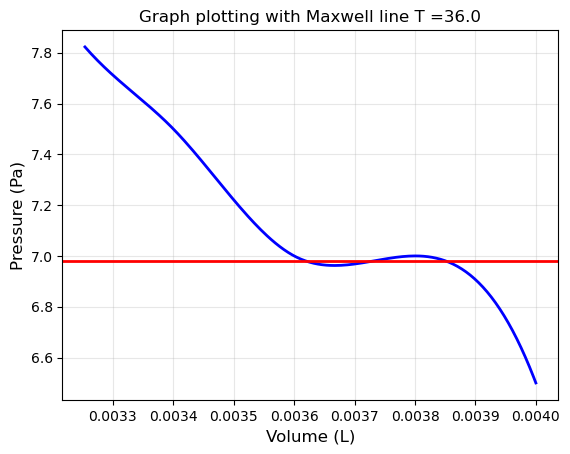

In [56]:

sheets = ["Sheet1","Sheet2","Sheet3","Sheet4","Sheet5","Sheet6","Sheet7","Sheet8"]
temperature = np.array([20.5,33,36,39,42,45,47,50])

datas = np.array([])
p_list = []
v_list = []

vapor_pressure = np.array([])
vapor_temperature = np.array([])

for i,p in enumerate(sheets):

    p_element = p_element_list[i]
    v_element = v_element_list[i]

    volume_fine = np.linspace(min(v_element), max(v_element), 1000)

    sorted_indices = np.argsort(v_element)
    volume = v_element[sorted_indices]
    pressure = p_element[sorted_indices]
    
    cs = inter.CubicSpline(volume, pressure)
    pressure_fine = cs(volume_fine)


    maxima_indices, _ = sig.find_peaks(pressure_fine)

    minima_indices, _ = sig.find_peaks(-pressure_fine)

    if len(maxima_indices) > 0 and len(minima_indices) > 0:

        v_max = volume_fine[maxima_indices[0]]
        p_max = pressure_fine[maxima_indices[0]]
        v_min = volume_fine[minima_indices[0]]
        p_min = pressure_fine[minima_indices[0]]
        
        print(f"\nSpinodal points:")
        print(f"  Local maximum: V = {v_max:.6f} m³, P = {p_max:.3f} Pa")
        print(f"  Local minimum: V = {v_min:.6f} m³, P = {p_min:.3f} Pa")
        

        def area_difference(P_m):
            """Calculate difference between areas above and below P_m"""

            crossings = np.where(np.diff(np.sign(pressure_fine - P_m)))[0]
            
            if len(crossings) < 3:
                return np.inf
                
            v1 = volume_fine[crossings[0]]  # Liquid temperature
            v2 = volume_fine[crossings[1]]  
            v3 = volume_fine[crossings[2]]  # Vapor temperature
            
            mask1 = (volume_fine >= v1) & (volume_fine <= v2)
            if np.sum(mask1) < 2:
                return np.inf
                
            v1_range = volume_fine[mask1]
            p1_range = pressure_fine[mask1]
            
            mask2 = (volume_fine >= v2) & (volume_fine <= v3)
            if np.sum(mask2) < 2:
                return np.inf
                
            v2_range = volume_fine[mask2]
            p2_range = pressure_fine[mask2]
            
            A1 = integ.simpson(p1_range - P_m, v1_range)
            A2 = integ.simpson(P_m - p2_range, v2_range)

            return abs(A1 - A2)
        
        bounds = (p_min, p_max)
        
        P_m_candidates = []
        area_diffs = []
        
        for P_start in np.linspace(p_min, p_max, 20):
            result = opt.minimize(area_difference, P_start, bounds=[bounds], method='L-BFGS-B')
            if result.success:
                P_m_candidates.append(result.x[0])
                area_diffs.append(result.fun)
        
        if P_m_candidates:
            best_idx = np.argmin(area_diffs)
            P_m = P_m_candidates[best_idx]
            
            crossings = np.where(np.diff(np.sign(pressure_fine - P_m)))[0]        
            if len(crossings) >= 3:
                v_liquid = volume_fine[crossings[0]]
                v_vapor = volume_fine[crossings[2]]
                
                v_zoom_min = v_liquid * 0.9
                v_zoom_max = v_vapor * 1.1
                zoom_mask = (volume_fine >= v_zoom_min) & (volume_fine <= v_zoom_max)
                
                plt.plot(volume_fine[zoom_mask], pressure_fine[zoom_mask], 'b-', linewidth=2)
                plt.axhline(y=P_m, color='red', linestyle='-', linewidth=2)
                print(P_m)
                vapor_pressure = np.append(vapor_pressure,P_m)
                vapor_temperature = np.append(vapor_temperature,temperature[i])
                

                
                """
                plt.scatter([v_liquid, v_max, v_min, v_vapor], 
                        [P_m, p_max, p_min, P_m], 
                        color=['green', 'orange', 'orange', 'green'], 
                        s=100, zorder=5)
                """
                
                plt.xlabel('Volume (L)', fontsize=12)
                plt.ylabel('Pressure (Pa)', fontsize=12)
                plt.title(f'Graph plotting with Maxwell line T ={temperature[i]}', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.show()

[ 6.96434254 -0.7502607 ]


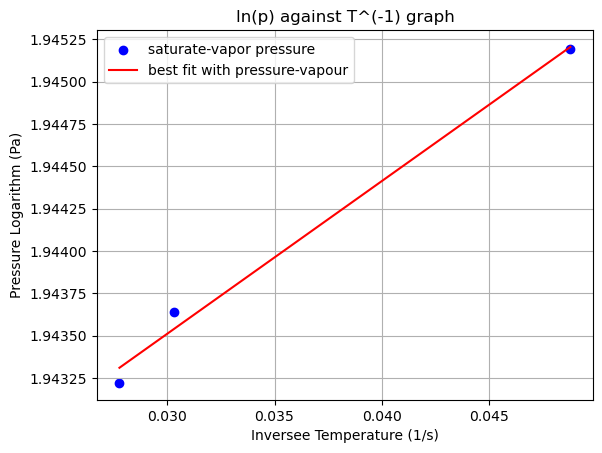

In [ ]:
def pressure_vapour(T,p_s0,Q):
    return np.log(p_s0) + (-Q*T/(R))

smooth_temp = np.linspace(1/vapor_temperature[0],1/vapor_temperature[-1],1000)

inverse_T = 1/vapor_temperature
ln_p = np.log(vapor_pressure)

#fit the line
popt, pcov = opt.curve_fit(pressure_vapour,inverse_T,ln_p)
pressure_fit = pressure_vapour(smooth_temp,*popt)
    

plt.title(f"ln(p) against T^(-1) graph")

plt.scatter(inverse_T,ln_p, label=r"saturate-vapor pressure", color='blue',)
#plt.scatter(vapor_temperature,vapor_pressure)
plt.plot(smooth_temp,pressure_fit,label="best fit with pressure-vapour",color="red")

print(popt)

plt.grid(True)
plt.xlabel("Inversee Temperature (1/s)")
plt.ylabel("Pressure Logarithm (Pa)")
plt.legend()
plt.show()